# Time Series Forecasting using Deep Learning 🧠 🤖 

## Setup ⚙ 💪
- Created a link with our Google Drive account in order to save the models.
- Clone the *data-science-dojo* repository and jump in it.
- Import all the dependencies for the project.
- Setup the path variables for the assests directories.

### Setup a link between the notebook and our Google Drive account

First the all, we have to establish a connection with our Google Drive account in order to save the trained models. 📈

In [1]:
# import drive module funtionalites
from google.colab import drive
drive.mount('/content/gdrive')

# this creates a symbolic link so that now the path /content/gdrive/My\ Drive/ is equal to /mydrive
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

Mounted at /content/gdrive
'Colab Notebooks'   HV_ELKIN_JAVIER_GUERRA_GALEANO.pdf	 Projects
 Documents	   'My Drive'				 TESTS


### Clone the *data-science-dojo* repository from Elkinmt19 GitHub account to start working with it. 😸

First clone the repository and jump in it in order to work with the files of the project.

In [2]:
# Clone the data-science-dojo repository
!git clone https://github.com/Elkinmt19/data-science-dojo.git

Cloning into 'data-science-dojo'...
remote: Enumerating objects: 406, done.
remote: Counting objects: 100% (406/406), done.
remote: Compressing objects: 100% (316/316), done.
remote: Total 406 (delta 165), reused 300 (delta 64), pack-reused 0
Receiving objects: 100% (406/406), 34.01 MiB | 16.42 MiB/s, done.
Resolving deltas: 100% (165/165), done.


In [3]:
# Get to the right directory of the repository
%cd data-science-dojo/tensorflow2.0-python/time_series_forecasting/scripts/

/content/data-science-dojo/tensorflow2.0-python/time_series_forecasting/scripts


In [4]:
# Install submodule of the repository
import IPython.display

# !pip install -e time_series_forecasting
# IPython.display.clear_output()

!cp ../time_series_forecasting/windows_generator.py ./

### Import all the dependencies that the project needs

In [5]:
# Built-in imports
import os

# External imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(6,3), 'figure.dpi':120})
import seaborn as sns; sns.set()
import tensorflow as tf

# Own imports 
import windows_generator as wg
import get_path_directory as gpd

### Setup the path variables for the assets directories
- To <assets/models/>
- To <assets/csvs/>

In [6]:
# Get directories path
ASSETS_FOLDER = gpd.get_directory_folder_path("assets")
MODELS_FOLDER = gpd.get_directory_folder_path("models")

## Exploratory Analysis and Feature Engineering 📎 📊

First, it is important to perform a good exploratory analysis and feature engineering of the data set in order to build a good forecasting model.

- Explore and preparate the data
- Feature engineering of the data

### Exploratory Analysis 
Explore the original dataset.

In [7]:
# define path function
def get_directory_path(directory_folder, file):
    path_dataset_file = os.path.join(
        directory_folder,
        file
    )

    return path_dataset_file

# Get the data from the csv file
df = pd.read_csv(get_directory_path(ASSETS_FOLDER,"csvs/time_series.csv"))

In [8]:
# Edit the DataFrame adding the date as the index 
date = pd.date_range('2010-01-01','2017-05-01', freq='M')
_ = df.pop("Unnamed: 0"); df.index = date
df.head()

,x
2010-01-31,6132.8
2010-02-28,5811.8
2010-03-31,4733.9
2010-04-30,4779.6
2010-05-31,4042.7


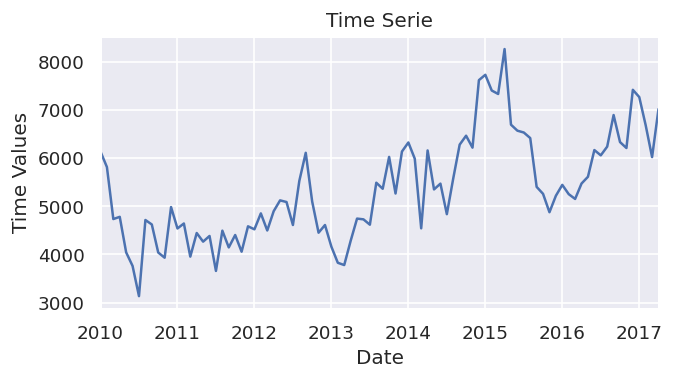

In [9]:
# Plot the time series to see and analyze its behavior
g = df.plot(legend=None);
plt.title("Time Serie");
plt.xlabel("Date");plt.ylabel("Time Values");

In [10]:
# Take a quick look at the statistics of the dataset
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
x,88.0,5360.060227,1084.084208,3135.3,4540.725,5233.6,6158.4,8258.5


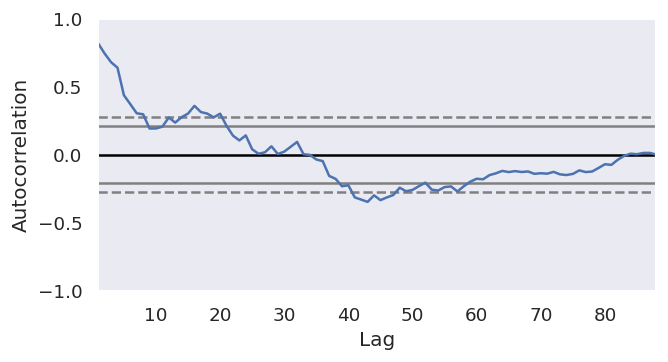

In [11]:
# Plot the autocorrelation plot of the time series
from pandas.plotting import autocorrelation_plot

g = autocorrelation_plot(df.x.tolist());

### Feature Engineering

Select and transform the most important features os the dataset in order to build a great model.

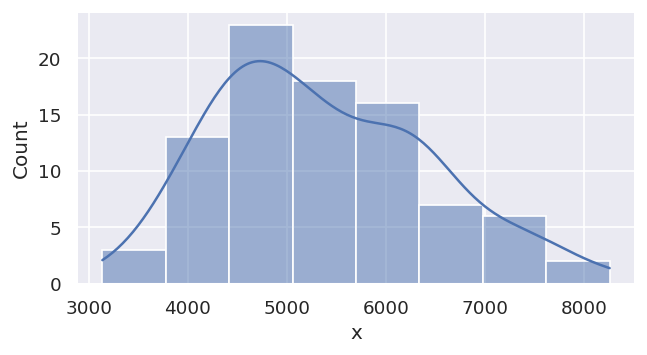

In [12]:
# Let's explore and see the distribution of the time series variable
g = sns.histplot(data=df, x='x', kde=True)

In [13]:
# Add some other features in order to have more information for the model
df["Mx"] = np.cos(df.x)
df["My"] = np.sin(df.x)
df["Mth"] = np.tanh(1 / df.x)

year = 12*24*60*60
timestamp_s = df.index.map(pd.Timestamp.timestamp)
df['year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['year cos'] = np.cos(timestamp_s * (2 * np.pi / year))
df.head()

,x,Mx,My,Mth,year sin,year cos
2010-01-31,6132.8,0.916666,0.399655,0.000163,-8.388263e-13,1.000000
2010-02-28,5811.8,0.989301,-0.145887,0.000172,8.660254e-01,-0.500000
2010-03-31,4733.9,-0.886935,0.461894,0.000211,-5.000000e-01,0.866025
2010-04-30,4779.6,-0.327090,-0.944993,0.000209,5.000000e-01,-0.866025
2010-05-31,4042.7,-0.862936,0.505313,0.000247,-5.996911e-13,1.000000


Text(0.5, 1.0, 'Time of year signal')

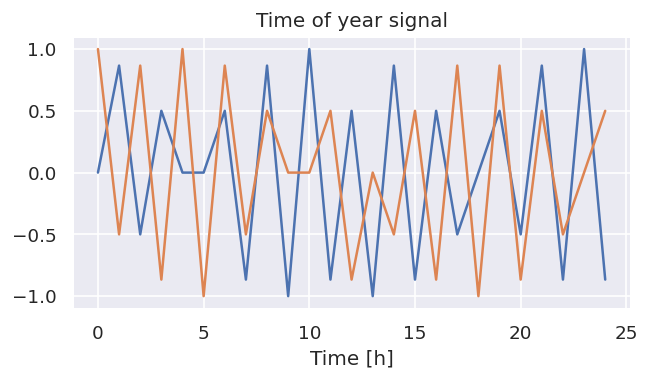

In [14]:
plt.plot(np.array(df['year sin'])[:25])
plt.plot(np.array(df['year cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of year signal')

In [15]:
# Split the dataset into train, evaluate and test datasets
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [16]:
# Normalize the data
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

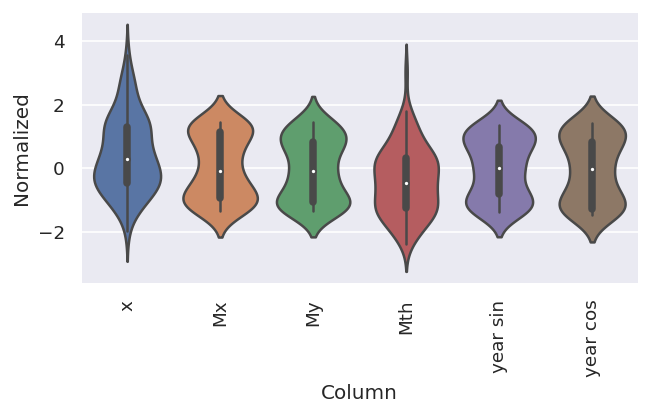

In [17]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

## Modeling 🧠 🤖

Now using the transformed data set it is possible to start building a model that allows to make a prediction of the time series, some of the most common and popular ML models are going to be used and tested.

- Data Split
- Setup the Tensorflow enviroment
- Multilayer Perceptron (MLP)
- Convoltional Neural Network (CNN)
- Long Short Term Memory (LSTM)

### Data Split 

The data set must now be divided according to a window that is chosen based on the analysis of the autocorrelation plot shown above.

In [202]:
# Split the dataset using a windows of 6 lags in time
CONV_WIDTH = 6 # Windows size
BATCH_SIZE = 8 # Number of batches

conv_window = wg.WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['x'],
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    batch_size=BATCH_SIZE
)

conv_window

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['x']

In [203]:
# Prepare the daset for the prediction
buff = []
for element in conv_window.complete.as_numpy_iterator(): 
    buff.append(tf.constant(element[0]))

ds_predict = np.concatenate(buff, axis=0)
print('Input shape:', ds_predict.shape)

Input shape: (82, 6, 6)


### Setup the Tensorflow enviroment 

Now it is necessary to configure the Tensorflow environment to work with the GPU of the machine in order to compile and adjust the models with the same structure.

In [204]:
# Setup the GPU configuration for Tensorflow
physical_devices = tf.config.experimental.list_physical_devices("GPU")
print("Num GPUs Available: ", len(physical_devices))
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


In [205]:
# Define and unique structure to compile and fit the models
MAX_EPOCHS = 1000

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(learning_rate=0.0001),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(
      window.train, epochs=MAX_EPOCHS,
      validation_data=window.val, batch_size=BATCH_SIZE,
      callbacks=[early_stopping]
  )
  return history

### Multilayer Perceptron

In [206]:
# Define the topology of the model
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [207]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (8, 6, 6)
Output shape: (8, 1, 1)


In [208]:
# Compile and fit the model
history = compile_and_fit(multi_step_dense, conv_window)

val_performance = {}
performance = {}

IPython.display.clear_output()
print(multi_step_dense.summary())
val_performance['multi_step_dense'] = multi_step_dense.evaluate(conv_window.val)
performance['multi_step_dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_9 (Flatten)         (None, 36)                0         
                                                                 
 dense_45 (Dense)            (None, 64)                2368      
                                                                 
 dense_46 (Dense)            (None, 1)                 65        
                                                                 
 reshape_9 (Reshape)         (None, 1, 1)              0         
                                                                 
Total params: 2,433
Trainable params: 2,433
Non-trainable params: 0
_________________________________________________________________
None
2/2 [==============================] - 0s 8ms/step - loss: 0.2393 - mean_absolute_error: 0.3734


In [209]:
# Make the prediction of the time series
x_prediction = multi_step_dense.predict(x=ds_predict, batch_size=BATCH_SIZE)
x_prediction = x_prediction.reshape((x_prediction.shape[0],))

print('Output shape:', x_prediction.shape)

Output shape: (82,)


Text(0.5, 0, 'Date')

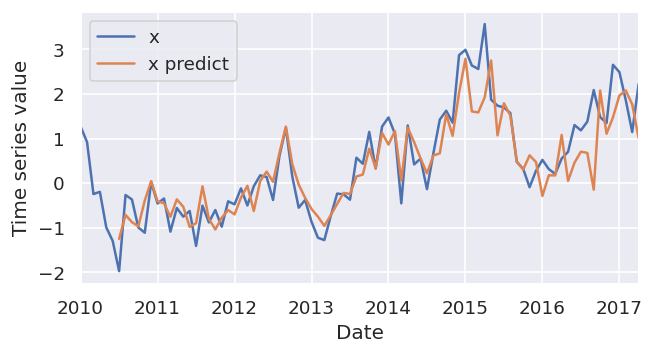

In [210]:
# Plot the original time series with the prediction along side
df_plot = conv_window.complete_df[["x"]]
df_plot["x predict"] = np.nan
df_plot["x predict"].iloc[df_plot.shape[0]-x_prediction.shape[0]:] = x_prediction
IPython.display.clear_output()

g = df_plot.plot()
plt.ylabel("Time series value")
plt.xlabel("Date")

### Convoltional Neural Network

In [211]:
# Define the topology of the model
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(
        filters=32,
        kernel_size=(CONV_WIDTH,),
        activation='relu'
    ),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [212]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (8, 6, 6)
Output shape: (8, 1, 1)


In [213]:
# Compile and fit the model
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
conv_model.summary()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 1, 32)             1184      
                                                                 
 dense_47 (Dense)            (None, 1, 32)             1056      
                                                                 
 dense_48 (Dense)            (None, 1, 1)              33        
                                                                 
Total params: 2,273
Trainable params: 2,273
Non-trainable params: 0
_________________________________________________________________
2/2 [==============================] - 0s 9ms/step - loss: 0.3292 - mean_absolute_error: 0.4772


In [214]:
# Make the prediction of the time series
x_prediction = conv_model.predict(x=ds_predict, batch_size=BATCH_SIZE)
x_prediction = x_prediction.reshape((x_prediction.shape[0],))

print('Output shape:', x_prediction.shape)

Output shape: (82,)


Text(0.5, 0, 'Date')

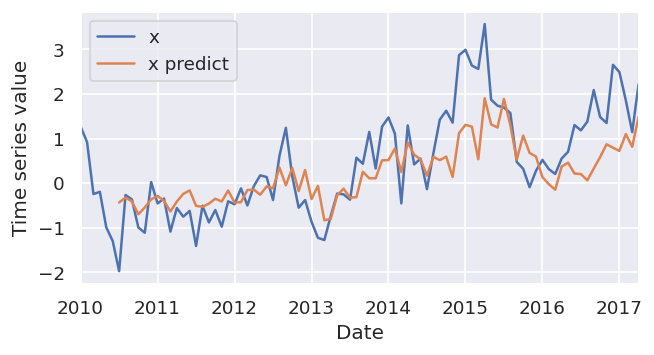

In [215]:
# Plot the original time series with the prediction along side
df_plot = conv_window.complete_df[["x"]]
df_plot["x predict"] = np.nan
df_plot["x predict"].iloc[df_plot.shape[0]-x_prediction.shape[0]:] = x_prediction
IPython.display.clear_output()

g = df_plot.plot()
plt.ylabel("Time series value")
plt.xlabel("Date")

### Long Short Term Memory

In [216]:
# Define the topology of the model
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [217]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', lstm_model(conv_window.example[0]).shape)

Input shape: (8, 6, 6)
Output shape: (8, 1)


In [218]:
# Compile and fit the model
history = compile_and_fit(lstm_model, conv_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(conv_window.val)
performance['LSTM'] = lstm_model.evaluate(conv_window.test, verbose=0)

2/2 [==============================] - 0s 8ms/step - loss: 0.2675 - mean_absolute_error: 0.4465


In [219]:
# Make the prediction of the time series
x_prediction = lstm_model.predict(x=ds_predict, batch_size=BATCH_SIZE)
x_prediction = x_prediction.reshape((x_prediction.shape[0],))

print('Output shape:', x_prediction.shape)

Output shape: (82,)


Text(0.5, 0, 'Date')

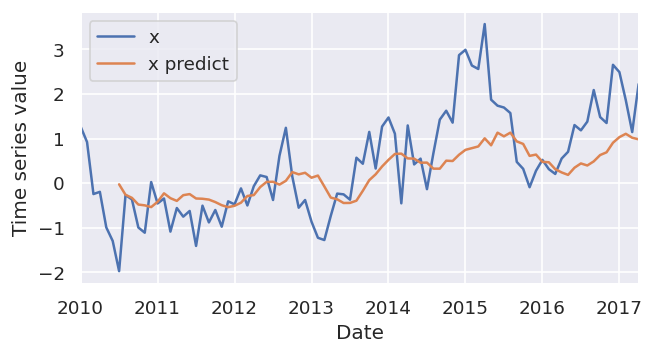

In [220]:
# Plot the original time series with the prediction along side
df_plot = conv_window.complete_df[["x"]]
df_plot["x predict"] = np.nan
df_plot["x predict"].iloc[df_plot.shape[0]-x_prediction.shape[0]:] = x_prediction
IPython.display.clear_output()

g = df_plot.plot()
plt.ylabel("Time series value")
plt.xlabel("Date")

### Performance of the models

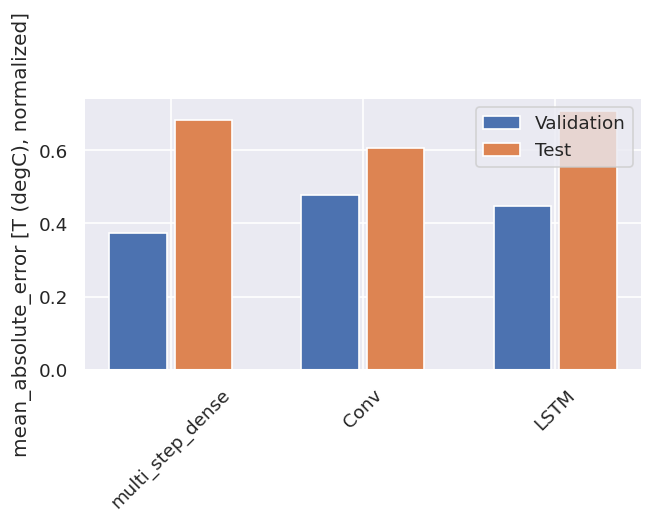

In [221]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()